# A Geoanalysis to the Efficiency of Health Center at San Diego
By Ruixuan Zhang A15413603, Lehan Li A15435934

##  Question(s) we addressed and its importance
<p>What is the characteristics of the place that have more clinics and health centers than other places? Does San Diego have an efficient health system? Covid has alerted us the importance of having a effective systems, so it is necessary to figure out how health center systems work. Thus, in this DSC170  project , we focus on the health systems in San Diego County and we want to figure out what patterns do the health centers in San Diego have and whether they are able to cover enough population.  We will focus on the analysis on  the dataset with demographic information, traffic system and clinics distribution information, mainly in zipcode. <p>
<p>Hypothesis:
We hypothesis that clinics are more likely to appear at place with large population and busy traffic, while hospital should be able to cover areas that have lower resistance to health issues such as Covid19. From our analysis, San Diego should have a relatively efficient health system and would be able to cover most of areas. <p>
<p>Business Value:
Our main audience would be government officials who are responsible for healthcare system in the county, and hospital staff who are supposed to take care about the capacity of the hospital. Investors who are interested in health care investment can also participate. If our analysis is different from the current situation, improvement such as increasing hospital’s capacity or building new clinics can be made to benefit more people who have a high demand in health caring , while unnecessary investment can be avoided if our result matches the current situation. <p>



## Background and Literature
- One of the most important standard to evaluate a healthcare facility is its efficiency. The efficiency of the hospital includes the allocation of services and resources, which means it is necessary to keep on track whether hospital has fully used its resources and reasonably allocate its service to the people nearby. Thus, factors such as location, kinds of services and capacity should be taken into consideration when doing such evaluation.  San Diego government states that they have built a complete healthcare system to meet the needs of people in the county, which having multiple health care center in different types . 
https://www.sandiegocounty.gov/hhsa/programs/phs/
https://www.ncbi.nlm.nih.gov/books/NBK436891/
- We also have a previous study from DSC170 2020 spring quarter, conducted byJerry Qian and Umang Saraf. Their study focuses on the efficiency of California Health System and allocation analysis. The result of their study shows that there is an inefficiency in California health system, and this cannot be solved by adding certain new health care center.  Our study will build on their logic of adding new points and exploring allocation result, though we focuses on San Diego County only, and we have totally different data sources and location decision-making. 
https://ucsdonline.maps.arcgis.com/home/notebook/notebook.html?id=a08444cdaea54e26985b88e959ea8f64

##  Python libraries or ArcGIS modules you used and why 

In this project, we mainly use 4 packages:

- Pandas: read data, basic manipulation in statistical analysis and minor  data cleaning
- Geopandas: read data, turn regular dataframe into Geodataframe then SDEF, calculate distance and join buffer with dataframe
- Shapely: creating new location points and make it geospatial so it can be used in future geoanalysis
- Arcgis: any other manipulation: including joining, map plotting, building layers and allocation analysis

For Arcgis package, we have imported many sub modules:  Geometry to help turn shapely shape into arcgis geometry form so it can be put in featurelayer; network which helps with allocation analysis; use_proximity to create buffers; FeatureLayerCollection to deal with all feature layers, extracting information and publishing new feature layers. 


In [32]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import arcgis
from arcgis.gis import GIS
from arcgis.features import FeatureLayerCollection
from arcgis.geometry import Geometry
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from IPython.display import display
from arcgis.features.analysis import *
from arcgis.features import use_proximity
from arcgis.mapping import WebMap
from arcgis.widgets import MapView
import getpass
%matplotlib inline 

username = input("Enter Username: ")
password = getpass.getpass("Enter Password: ")
gis = GIS(username=username, password=password)

Enter Username: dsc170wi22_22
Enter Password: ········


## Data sources

-  Health center
https://services2.arcgis.com/wi1yEacfYjH5viqb/ArcGIS/rest/services/CDPH_Licensing_and_Certification_Healthcare_Facilities/FeatureServer
CDPH (California Department of Public Health)Licensed Health Center.


- Population information
https://services2.arcgis.com/wi1yEacfYjH5viqb/ArcGIS/rest/services/CA_zip_codes/FeatureServer
Population in zipcode. We pay more attention to the population under 19 and over 65 since these groups are the one need more healthcare services. 

- Traffic information
Highway information from https://services1.arcgis.com/1vIhDJwtG5eNmiqX/ArcGIS/rest/services/highways/FeatureServer



- CDC's Social Vulnerability Index (SVI) https://services3.arcgis.com/ZvidGQkLaDJxRSJ2/arcgis/rest/services/CDC_Social_Vulnerability_Index_2018/FeatureServer
SVI is a tool, created by the Geospatial Research, Analysis & Services Program (GRASP), to help public health officials and emergency response planners identify and map the communities that will most likely need support before, during, and after a hazardous event. The tract-level SVI shows the relative vulnerability of the population of every U.S. Census tract. The county-level SVI shows the relative vulnerability of every U.S. county population. The SVI ranks tracts (or counties) on 15 social factors, described in detail in the documentation. The tract (or county) rankings for individual factors are further grouped into four related themes. Thus each enumeration unit receives a ranking for each Census variable and for each of the four themes, as well as an overall ranking.
- County owned Vancant Location
https://services1.arcgis.com/eGSDp8lpKe5izqVc/arcgis/rest/services/San_Diego_Vacant_Lots/FeatureServer
These undeveloped areas will be a good resouce for future hospital

Each dataset has a good data quality, neither having too many missing data nor invalid data forms

In [33]:
# healthcenter
healthserviceURL =  'https://services2.arcgis.com/wi1yEacfYjH5viqb/ArcGIS/rest/services/CDPH_Licensing_and_Certification_Healthcare_Facilities/FeatureServer'
healthitem = FeatureLayerCollection(healthserviceURL, gis=gis)
health_center = pd.DataFrame.spatial.from_layer(healthitem.layers[0])

In [34]:
health_center.head()

,BED_COUNT,Bed_Table_Styled,CONTACT_PHONE_NUMBER,COUNTY_NAME,DISTRICT_NAME,FACID,FACNAME,FAC_ADDRESS1,FAC_ADDRESS2,FAC_CITY,...,Licensee_Type,Long_Term_Care,OBJECTID,PROVIDER_NUMBER,Pediatric_Trauma_Center,SHAPE,Services_List,Trauma_Center,XCOORD,YCOORD
0,67,"<table style=""border:1px solid black; border-c...",(209) 557-6360,STANISLAUS,Fresno District Office,030001568,DOCTORS MEDICAL CENTER - BEHAVIORAL HEALTH DEP...,1501 Claus Rd,,Modesto,...,Profit Corp,NON-LTC,1,054088,None,"{""x"": -120.92205599999994, ""y"": 37.66542300000...",<ul><li>Outpatient Services - Psychiatry - Par...,None,-120.922056,37.665423
1,106,"<table style=""border:1px solid black; border-c...",(909) 625-5411,SAN BERNARDINO,San Bernardino District Office,240000009,MONTCLAIR HOSPITAL MEDICAL CENTER,5000 San Bernardino St,,Montclair,...,Limited Liability Company,NON-LTC,2,050758,None,"{""x"": -117.69579449999998, ""y"": 34.07870700000...",<ul><li>Basic Emergency Medical</li><li>Physic...,None,-117.695795,34.078707
2,199,"<table style=""border:1px solid black; border-c...",(562) 698-0811,LOS ANGELES,L.A. Acute/Ancillary Unit,930000052,PIH Health Hospital - Downey,11500 Brookshire Ave,,Downey,...,Nonprofit Corp,NON-LTC,3,050393,None,"{""x"": -118.13098049999996, ""y"": 33.93430200000...",<ul><li>Basic Emergency Medical</li><li>Cardia...,None,-118.130981,33.934302
3,102,"<table style=""border:1px solid black; border-c...",(323) 260-4126,LOS ANGELES,L.A. Acute/Ancillary Unit,930000053,East Los Angeles Doctors Hospital,4060 E Whittier Blvd,,Los Angeles,...,Partnership,NON-LTC,4,050641,None,"{""x"": -118.18403999999998, ""y"": 34.02371700000...",<ul><li>Basic Emergency Medical</li><li>Nuclea...,None,-118.184040,34.023717
4,138,"<table style=""border:1px solid black; border-c...",(424) 522-7271,LOS ANGELES,L.A. Acute/Ancillary Unit,930000031,"California Rehabilitation Institute, LLC",2070 Century Park E,,Los Angeles,...,Limited Liability Company,NON-LTC,5,053039,None,"{""x"": -118.41227099999998, ""y"": 34.05906000000...",<ul><li>Occupational Therapy</li><li>Outpatien...,None,-118.412271,34.059060


In [35]:
# population 

In [36]:
population_serviceURL = 'https://services2.arcgis.com/wi1yEacfYjH5viqb/ArcGIS/rest/services/CA_zip_codes/FeatureServer'
popitem = FeatureLayerCollection(population_serviceURL , gis=gis)
population= pd.DataFrame.spatial.from_layer(popitem.layers[0])

In [37]:
population.head()

,FID,objectid,cnty_fips,county,tract,tract_id,census_key,zcta,zcta_key,latitude,...,hu_vac_sea,hu_occ_own,hu_occ_o_1,hu_occ_ren,hu_occ_r_1,shape_area,shape_len,Shape__Area,Shape__Length,SHAPE
0,1,1,,,,,,94601,0694601,37.776711,...,28,4764,16528,10062,32927,8.721649e+06,15265.093880,1.398404e+07,19330.602209,"{""rings"": [[[-13606266.4367911, 4550079.548938..."
1,2,2,,,,,,94501,0694501,37.774084,...,189,10286,26023,14739,32705,2.954478e+07,27119.154912,4.736799e+07,34332.226973,"{""rings"": [[[-13613461.7947188, 4546000.676133..."
2,3,3,,,,,,94560,0694560,37.520360,...,17,8942,28489,4030,13939,3.581839e+07,30752.336176,5.703840e+07,38807.672458,"{""rings"": [[[-13587099.446927, 4515992.6357856..."
3,4,4,,,,,,94587,0694587,37.603151,...,39,13580,46272,6853,22726,5.107510e+07,53110.314427,8.151313e+07,67091.140357,"{""rings"": [[[-13588230.7868463, 4523753.642875..."
4,5,5,,,,,,94580,0694580,37.676958,...,15,6105,18760,2519,8252,8.946896e+06,20260.685185,1.430692e+07,25619.061146,"{""rings"": [[[-13595447.9633723, 4534945.007610..."


In [38]:
#highway

In [39]:
highwayserviceURL =  'https://services1.arcgis.com/1vIhDJwtG5eNmiqX/ArcGIS/rest/services/highways/FeatureServer'
highwayitem = FeatureLayerCollection(highwayserviceURL, gis=gis)
highway = pd.DataFrame.spatial.from_layer(highwayitem.layers[0])

In [40]:
highway.head()

,OBJECTID,NAME_FULL,NAME,LBL,LBL_TYPE,GlobalID,Shape__Length,SHAPE
0,1,INTERSTATE 5,I-5,5,Interstate,ce99a809-9ea3-4619-a291-826005729e15,381247.315488,"{""paths"": [[[6151557.99988772, 2090464.0001640..."
1,2,INTERSTATE 8,I-8,8,Interstate,dab016f6-7d30-407d-8e19-0059d55f830b,409675.951324,"{""paths"": [[[6606058.00000636, 1814640.9999761..."
2,3,INTERSTATE 805,I-805,805,Interstate,d04c1d1d-2a60-4fec-8e70-524c80ddc75e,148983.000233,"{""paths"": [[[6262202.00010568, 1911216.0000447..."
3,4,STATE ROUTE 125,SR-125,125,State Route,c50db71d-f8d6-478a-bfae-b39dcb5ee3a6,106240.634868,"{""paths"": [[[6325585.72599038, 1832234.1580201..."
4,5,STATE ROUTE 163,SR-163,163,State Route,98b9342f-5273-423e-a4cf-3d334acf82f9,58025.743877,"{""paths"": [[[6297898.99988472, 1896254.0001124..."


In [41]:
roadserviceURL =  'https://services9.arcgis.com/mXNwDpiENQiMIzRv/arcgis/rest/services/UC_San_Diego_Roads/FeatureServer'
roaditem = FeatureLayerCollection(roadserviceURL, gis=gis)
road = pd.DataFrame.spatial.from_layer(roaditem.layers[0])
road.head()

,OBJECTID,ROADSEGID,LLOWADDR,RHIGHADDR,SPEED,RD30FULL,SHAPE_STLe,GlobalID,Shape__Length,SHAPE
0,1,24545,2170,2199,20,NAGA WAY,332.000995,c20664cb-569e-428c-8e9c-6a7969fa6f17,332.000876,"{""paths"": [[[6253758.99629542, 1896467.7874293..."
1,2,104011,8900,8949,10,BIOLOGICAL GRADE,219.301583,25eb40e6-fdb4-4506-bf60-f198310e0767,219.301335,"{""paths"": [[[6254008.00006251, 1898018.9998780..."
2,3,24549,9300,9309,10,DISCOVERY WAY,436.125476,0e036507-1970-4c25-b192-1689e374f77e,436.055189,"{""paths"": [[[6254964.000119, 1897476.99997784]..."
3,4,24546,8700,8829,20,BIOLOGICAL GRADE,957.847038,6bb881ed-9c85-4796-93ab-daf69c87609c,957.847036,"{""paths"": [[[6253758.99629542, 1896467.7874293..."
4,5,54725,9390,9399,20,REDWOOD DR,175.138945,aab59e94-e75a-444b-9795-aaa0dd96bdd2,175.139266,"{""paths"": [[[6255784.00011942, 1898195.0008384..."


In [42]:
SVIserviceURL =  'https://services3.arcgis.com/ZvidGQkLaDJxRSJ2/arcgis/rest/services/CDC_Social_Vulnerability_Index_2018/FeatureServer'
SVIitem = FeatureLayerCollection(SVIserviceURL, gis=gis)
SVI = pd.DataFrame.spatial.from_layer(SVIitem.layers[1])
SVI

,AREA_SQMI,COUNTY,EPL_AGE17,EPL_AGE65,EPL_CROWD,EPL_DISABL,EPL_GROUPQ,EPL_LIMENG,EPL_MINRTY,EPL_MOBILE,...,SPL_THEME2,SPL_THEME3,SPL_THEME4,SPL_THEMES,ST,STATE,STCNTY,ST_ABBR,Shape__Area,Shape__Length
0,3.790677,Autauga,0.4188,0.3451,0.1999,0.7897,0.0000,0.3889,0.3717,0.8723,...,2.1038,0.7606,1.1418,5.6169,01,ALABAMA,01001,AL,1.392797e+07,18815.905607
1,1.284051,Autauga,0.3759,0.4216,0.2952,0.7692,0.9469,0.3656,0.7457,0.5741,...,1.8082,1.1113,2.8445,8.4038,01,ALABAMA,01001,AL,4.686141e+06,11574.539473
2,2.065365,Autauga,0.6384,0.5877,0.5416,0.9040,0.0000,0.6799,0.5424,0.5669,...,2.6595,1.2223,2.0682,8.1157,01,ALABAMA,01001,AL,7.579649e+06,12438.415290
3,2.464982,Autauga,0.3687,0.8851,0.2952,0.8616,0.0000,0.5014,0.2456,0.0000,...,2.4903,0.7470,0.8862,5.0829,01,ALABAMA,01001,AL,8.949513e+06,14425.354617
4,4.404987,Autauga,0.7239,0.4094,0.2179,0.6766,0.7678,0.4116,0.4269,0.4360,...,2.2336,0.8385,2.6824,7.0198,01,ALABAMA,01001,AL,1.614732e+07,20016.274039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72832,2231.946143,Washakie,0.3232,0.8252,0.6159,0.7555,0.7908,0.0000,0.2382,0.9100,...,2.3033,0.2382,3.0681,7.4410,56,WYOMING,56043,WY,1.115676e+10,570674.075908
72833,0.769580,Washakie,0.6778,0.6191,0.4325,0.5503,0.7313,0.2767,0.4502,0.7253,...,2.4621,0.7269,2.5370,7.7048,56,WYOMING,56043,WY,3.852027e+06,8166.204599
72834,5.957250,Washakie,0.8345,0.8830,0.2699,0.5968,0.8224,0.3656,0.3446,0.6843,...,2.5558,0.7102,2.4127,8.2555,56,WYOMING,56043,WY,3.112586e+07,44243.214459
72835,2355.226087,Weston,0.1975,0.7903,0.6916,0.7815,0.9405,0.2767,0.2270,0.9081,...,2.2169,0.5037,3.2011,7.5359,56,WYOMING,56045,WY,1.173133e+10,515503.040699


In [43]:

VacantserviceURL =  'https://services1.arcgis.com/eGSDp8lpKe5izqVc/arcgis/rest/services/San_Diego_Vacant_Lots/FeatureServer'
Vacantitem = FeatureLayerCollection(VacantserviceURL, gis=gis)
Vacant = Vacantitem.layers[0].query(out_sr=3857).sdf

 ## Data cleaning

We have several datasets in this project, so we have to combine several data frames and layers together.All dataset we find have a complete metadata with a provenance from government dataset. Most of the data come from official record system. Thus, we assume that the accuracy of the datasets can be ensured. Thus, for data cleaning part, we only have to drop useless columns and limit the range to the San Diego area

In [44]:
# remove unnecessary column, only take san diego part

In [45]:
zip_tract = pd. read_csv('/datasets/ds170-wi22-a00-public/hud/ZIP_TRACT_122021_san_diego.csv')
zip_tract

,zip,tract,usps_zip_pref_city,usps_zip_pref_state,res_ratio,bus_ratio,oth_ratio,tot_ratio
0,92003,6073018803,BONSALL,CA,0.504052,0.078652,0.567568,0.462649
1,92003,6073018612,BONSALL,CA,0.013092,0.002809,0.000000,0.011941
2,92003,6073019207,BONSALL,CA,0.008416,0.008427,0.000000,0.008331
3,92003,6073018611,BONSALL,CA,0.028990,0.000000,0.000000,0.025826
4,92003,6073018802,BONSALL,CA,0.445449,0.910112,0.432432,0.491252
...,...,...,...,...,...,...,...,...
1066,92110,6073009102,SAN DIEGO,CA,0.016247,0.000351,0.001626,0.012567
1067,92110,6073006900,SAN DIEGO,CA,0.022578,0.000000,0.001626,0.017338
1068,92110,6073009103,SAN DIEGO,CA,0.118307,0.033708,0.028455,0.097859
1069,92110,6073006300,SAN DIEGO,CA,0.002136,0.000000,0.000000,0.001629


In [46]:
# taking san diego part of health center
health_center_cleaned = health_center[health_center['COUNTY_NAME']=='SAN DIEGO']
health_center_cleaned = health_center_cleaned.drop(columns=['CONTACT_PHONE_NUMBER','HFCIS_LINK',
                                                            'PROVIDER_NUMBER','Licensee_Business_Name',
                                                            'Licensee_First_Name'])

In [47]:
zipcode = zip_tract['zip'].unique()
population['zcta']=population['zcta'].astype(int)
population_cleaned = population[population['zcta'].isin(zipcode)]
select_columns = ['zcta','tot_pop',
       'age_under5', 'age_5to9', 'age_10to14', 'age_15to19', 'age_20to24',
       'age_25to29', 'age_30to34', 'age_35to39', 'age_40to44', 'age_45to49',
       'age_50to54', 'age_55to59', 'age_60to64', 'age_65to69', 'age_70to74',
       'age_75to79', 'age_80to84', 'age_85_ove', 'age16_over', 'age18_over',
       'age21_over', 'age62_over', 'age65_over', 'male', 'female', 'SHAPE']
population_cleaned =population_cleaned [select_columns]

In [48]:
population_cleaned

,zcta,tot_pop,age_under5,age_5to9,age_10to14,age_15to19,age_20to24,age_25to29,age_30to34,age_35to39,...,age_80to84,age_85_ove,age16_over,age18_over,age21_over,age62_over,age65_over,male,female,SHAPE
159,92014,13154,462,600,729,649,446,658,685,677,...,340,278,11212,10902,10632,3528,2747,6509,6645,"{""rings"": [[[-13054265.2533412, 3892683.172670..."
160,92020,57767,4289,3777,3757,4245,4693,4520,3812,3689,...,1071,1112,45100,43394,40825,8589,7000,28375,29392,"{""rings"": [[[-13019454.4240489, 3863881.247673..."
161,92111,45096,2842,2663,2687,2782,3631,3989,3565,3168,...,919,822,36357,35240,33433,7033,5785,22275,22821,"{""rings"": [[[-13042721.7560844, 3872211.344049..."
162,92108,18858,810,331,210,491,3227,3939,2777,1562,...,173,310,17462,17359,16598,1670,1358,9446,9412,"{""rings"": [[[-13046407.8784168, 3863518.006106..."
163,92037,46781,1714,1701,1706,6884,5445,3473,2606,2275,...,1458,1635,41312,40570,32733,10141,8618,22678,24103,"{""rings"": [[[-13055817.3810031, 3872255.325060..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715,91901,17403,904,1021,1321,1444,1012,830,825,884,...,277,265,13874,13203,12493,2979,2311,8750,8653,"{""rings"": [[[-13002375.8990526, 3876333.017765..."
1716,92115,58560,3854,3142,2840,6065,10022,5316,4099,3789,...,803,987,48120,46935,39923,6134,5013,29075,29485,"{""rings"": [[[-13031852.4097151, 3861127.165218..."
1717,92145,1449,163,176,119,96,52,91,84,137,...,6,4,964,925,889,74,50,713,736,"{""rings"": [[[-13027955.2255935, 3884952.420990..."
1718,92066,378,18,25,12,13,12,13,23,13,...,4,3,320,316,307,94,64,195,183,"{""rings"": [[[-12974186.6870369, 3921574.961690..."


In [49]:
#highway and road are already clean

In [50]:
SVI_cleaned = SVI[SVI['COUNTY']=='San Diego']
SVI_cleaned

,AREA_SQMI,COUNTY,EPL_AGE17,EPL_AGE65,EPL_CROWD,EPL_DISABL,EPL_GROUPQ,EPL_LIMENG,EPL_MINRTY,EPL_MOBILE,...,SPL_THEME2,SPL_THEME3,SPL_THEME4,SPL_THEMES,ST,STATE,STCNTY,ST_ABBR,Shape__Area,Shape__Length
9207,0.595159,San Diego,0.1933,0.9602,0.1810,0.2848,0.0000,0.6393,0.4205,0.000,...,1.4680,1.0598,1.2225,4.1485,06,CALIFORNIA,06073,CA,2.202565e+06,6584.292664
9208,0.333674,San Diego,0.1484,0.9554,0.5281,0.3138,0.0000,0.4326,0.3035,0.000,...,1.5494,0.7361,2.1919,5.1774,06,CALIFORNIA,06073,CA,1.206844e+06,4264.520966
9209,0.504249,San Diego,0.0944,0.3801,0.0000,0.2995,0.7097,0.5536,0.4848,0.000,...,0.9918,1.0384,2.2285,4.9130,06,CALIFORNIA,06073,CA,1.861595e+06,6314.942655
9210,0.347014,San Diego,0.0255,0.5939,0.6373,0.3600,0.8846,0.2767,0.4739,0.000,...,1.0543,0.7506,3.0093,6.1199,06,CALIFORNIA,06073,CA,1.282944e+06,4990.849900
9211,0.454616,San Diego,0.0322,0.1446,0.6270,0.0192,0.9256,0.7442,0.5871,0.000,...,0.3757,1.3313,3.0689,5.8237,06,CALIFORNIA,06073,CA,1.687292e+06,5494.054121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9829,1.226122,San Diego,0.5681,0.4887,0.2952,0.4483,0.9759,0.3103,0.5261,0.000,...,1.9684,0.8364,2.5410,6.8770,06,CALIFORNIA,06073,CA,2.018657e+07,21224.947218
9830,0.551908,San Diego,0.2982,0.8783,0.0000,0.3138,0.0000,0.0000,0.3335,0.000,...,1.5557,0.3335,1.0196,3.2383,06,CALIFORNIA,06073,CA,2.075571e+06,8567.043910
9831,2.318119,San Diego,0.0273,0.0184,0.9709,0.2547,0.9931,0.7442,0.8048,0.000,...,1.2396,1.5490,3.2159,8.6071,06,CALIFORNIA,06073,CA,1.503868e+07,32207.031857
9832,0.302002,San Diego,0.3628,0.2035,0.8897,0.4790,0.7908,0.9215,0.9277,0.000,...,1.9345,1.8492,3.3220,10.4134,06,CALIFORNIA,06073,CA,1.108351e+06,6261.814846


## Descriptive statistics for the data

### Part 1: Number of Kids and Elderly in areas

For the first part of the descriptive statistics, the project seeks to inverstigat the total number of children and elderly in the neigborhood, as well as the relative proportion to the entire population in the neighborhood. Since children and elderly people are more susceptible to virus, they tends to seek medical treatments more often than other people. Thus, it's essential to understand the population distribution of kids and elderly in order to provide better medical allocation system. And if the hospital is not adequate around the area where kids and elderly are heavily populated, future improvement might be to be done to enhance the general medical system in San Diego

Visualization is provided based on the total kid / elderly population for each zip code, as well as the proportion of kid / elderly for each zip code.

### Number of Kids in areas

#### Total number of kids based on zipcode

In [51]:
# Kid is defined as person who's under 19 years old
population_cleaned['age19_below'] = population_cleaned['age_under5'] + population_cleaned['age_5to9'] + population_cleaned['age_10to14'] + population_cleaned['age_15to19']

map1 = gis.map("San Diego")
population_cleaned.spatial.plot(map_widget=map1,
                 renderer_type='c',  # for class breaks renderer
                 method='esriClassifyNaturalBreaks',  # classification algorithm
                 class_count=10,  # choose the number of classes
                 col='age19_below',  # numeric column to classify
                 cmap='prism',  # color map to pick colors from for each class
                 alpha=0.3  # specify opacity
                )
map1

MapView(layout=Layout(height='400px', width='100%'))

#### Proportion of kids based on total population

In [52]:
population_cleaned['prop_19'] = population_cleaned['age19_below'] / population_cleaned['tot_pop']

map2 = gis.map("San Diego")
population_cleaned.spatial.plot(map_widget=map2,
                 renderer_type='c',  # for class breaks renderer
                 method='esriClassifyNaturalBreaks',  # classification algorithm
                 class_count=10,  # choose the number of classes
                 col='prop_19',  # numeric column to classify
                 cmap='prism',  # color map to pick colors from for each class
                 alpha=0.3  # specify opacity
                )
map2

MapView(layout=Layout(height='400px', width='100%'))

In general, the regional difference of the total number of kids and the relative number of kids is not too significant. While the majority of kids locates in the central San Diego area and the east side of San Diego, the rest of the area also holds relatively high population of kids. 

The discrepancy between total number of kids and proportion of kids over entire population in the neighborhood is relatively small. The area with a higher total number of kids tends to also have a higher proportion of kids compared to the entire population. 

### Number of Elderly in areas

#### Total number of elderly based on zipcode

In [53]:
# Elderly is defined as person who's above 65 years old
map3 = gis.map("San Diego")
population_cleaned.spatial.plot(map_widget=map3,
                 renderer_type='c',  # for class breaks renderer
                 method='esriClassifyNaturalBreaks',  # classification algorithm
                 class_count=10,  # choose the number of classes
                 col='age65_over',  # numeric column to classify
                 cmap='prism',  # color map to pick colors from for each class
                 alpha=0.3  # specify opacity
                )
map3

MapView(layout=Layout(height='400px', width='100%'))

#### Proportion of elderly based on total population

In [54]:
# Elderly is defined as person who's above 65 years old
population_cleaned['prop_65'] = population_cleaned['age65_over'] / population_cleaned['tot_pop']

map4 = gis.map("San Diego")
population_cleaned.spatial.plot(map_widget=map4,
                 renderer_type='c',  # for class breaks renderer
                 method='esriClassifyNaturalBreaks',  # classification algorithm
                 class_count=10,  # choose the number of classes
                 col='prop_65',  # numeric column to classify
                 cmap='prism',  # color map to pick colors from for each class
                 alpha=0.3  # specify opacity
                )
map4

MapView(layout=Layout(height='400px', width='100%'))

For the total number of elderly in San Diego, elderly population is densely located in the east side of San Diego compared to the west side of San Diego. The elderly population is also densely located in the central San Diego area. The total number is smaller especially near the border line which is adjacent to Mexicao Tijuana. 

The discrepancy between total number of elderly and proportion of elderly over entire population in the neighborhood is significant. The proportionf of elderly residents in San Diego is distributed relatively uniform, where the difference between each neighborhood is not significant. Except for the upper east side of San Diego, where the relative proportion for elderly  is lower

### Part 2: Hospital Bed Count 

One of the metrics to measure the patient intake system is the bed count. It determines the number of inpatients a hostipal can support. With greater number of bed count, the hostipal is capable to taking more patients and is a more reliable medical treatment source. The area with relatively lower total number of hospital bed count might need to be improved. 

In [55]:
# convert zipcode into int, and sum all bed count within each zip code regions
health_center_cleaned['FAC_ZIP5'] = health_center_cleaned['FAC_ZIP5'].astype(int)
health_center_zip = health_center_cleaned.merge(population_cleaned, left_on = 'FAC_ZIP5', right_on = 'zcta')
health_center_zip['zcta']

health_center_case = health_center_zip.groupby('zcta')['BED_COUNT'].sum().reset_index()
health_center_case = health_center_case.merge(health_center_zip[['zcta','SHAPE_y']], on =['zcta'])
health_center_case['SHAPE'] = health_center_case['SHAPE_y']

map6 = gis.map("San Diego")
health_center_case.spatial.plot(map_widget=map6,
                 renderer_type='c',  # for class breaks renderer
                 method='esriClassifyNaturalBreaks',  # classification algorithm
                 class_count=10,  # choose the number of classes
                 col='BED_COUNT',  # numeric column to classify
                 cmap='prism',  # color map to pick colors from for each class
                 alpha=0.3  # specify opacity
                )
map6

MapView(layout=Layout(height='400px', width='100%'))

The general distribution of hospital bed count is roughly uniform across all San Diego area except for some areas in the middle east side of San Diego and one neighborhood in the central San Diego area. The relative smaller number of bed count in the central San Diego area is less likely to be problematic since it's surrounded by neighborhoods with enough hospital beds. The partient in one area could be easily transferred to nearby hospital under emerency situations. 

### Part 3: Hostipal Type

There are many different types of hostipal in San Diego, this project seeks to visualize the proportion of each types of hospital to offer a general overview of the hospital type. 

In [56]:
health_center_cleaned['Facility_Type_Description'].value_counts()

Community Clinic                                                      210
Home Health Agency                                                     98
Hospice                                                                89
Skilled Nursing Facility                                               84
Intermediate Care Facility/Developmentally Disabled - Habilitative     74
Ambulatory Surgical Center                                             50
Chronic Dialysis Clinic                                                36
General Acute Care Hospital                                            24
Outpatient/Speech Pathologist                                          22
Intermediate Care Facility/Developmentally Disabled - Nursing          20
Adult Day Health Care                                                  20
Acute Psychiatric Hospital                                             12
Free Clinic                                                            10
Congregate Living Health Facility     

In [57]:
map7 = gis.map("San Diego")
health_center_cleaned.spatial.plot(map_widget=map7, 
                        renderer_type='u', # specify the unique value renderer using its notation 'u'
                        col='Facility_Type_Description'  # column to get unique values from
                       )
map7.legend = True
map7

MapView(layout=Layout(height='400px', width='100%'), legend=True)

We can see that most health centers are Community Clinics, Home Health Agency, Hospice  , Skilled Nursing Facility, Intermediate Care Facility/Developmentally Disabled - Habilitative and Ambulatory Surgical Center. These types of hospital takes up roughly 75% of the entire hospital.   

### Part 4: Bus Ratio

Transportation is one of the significant aspects in hospital. If the bus ratio is relatively high in the area, then people could have a option of going to the hospital, and the commute time to the hospital could be shorter

In [58]:
zip_tract['zip'] = zip_tract['zip'].astype(int)
zip_tract_pop = zip_tract.merge(population_cleaned, left_on = 'zip', right_on = 'zcta')

map7 = gis.map("San Diego")
health_center_case.spatial.plot(map_widget=map7,
                 renderer_type='c',  # for class breaks renderer
                 method='esriClassifyNaturalBreaks',  # classification algorithm
                 class_count=10,  # choose the number of classes
                 col='bus_ratio',  # numeric column to classify
                 cmap='prism',  # color map to pick colors from for each class
                 alpha=0.3  # specify opacity
                )
map7

MapView(layout=Layout(height='400px', width='100%'))

The bus ratio is relatively the same across all San Diego neighborhood, while the middle east side tends to have a smaller ratio of bus routes. 

## Analysis

In this part, we have 6 steps in total, which first identify the pattern of health center at San Diego, then add new facilty to see if it can help with efficiency: 
1. Create buffers around all hospital locations in hospital_layer
2. Find overlay of area not covered by the buffers among all zipcode 
3. Use find_centroids to locate centroids in each clipped zipcode to serve as demand points
4. Remove vacant land that is far from freeway, take a closest unused land for each centroid and find the closest point
5. Update weights of input factors with SVI data in each zipcode
6. Run solve_location_allocation algorithm with maximum attendance problem to see if we finish the problem


In [59]:
# We first set the coordinate system unified and introduce arcgis geometry
zip_information = gpd.read_file('Final Data/ZCTA2010.shp').to_crs('EPSG:3857')
zip_information=zip_information[['ZCTA','geometry']]
zip_information['ZCTA'] = zip_information['ZCTA'].astype('int')
population_cleaned_df = population_cleaned.merge(zip_information, left_on ='zcta' , right_on='ZCTA').drop(columns = ['SHAPE'])

In [60]:
# make_layer of health center
#gis.content.search(query='San Diego Health Center 170', max_items=100, item_type="Feature Layer")[0].delete()
health_center_layer= health_center_cleaned.spatial.to_featurelayer(title='San Diego Health Center 170',
                                                                   gis=gis, tags='sample')

In [61]:
# make layer of zipcode information
#gis.content.get('f53d9584b11f494fa462b2f368e6a407').delete()
population_layer= population_cleaned.spatial.to_featurelayer(title='San Diego Population 170',gis=gis, tags='sample')
population_layer.id                                                              

'333345daafa54063a8a528b5e5fdd003'

### Step 1 & Step2
First, we make a buffer area for each hospital, we set 10 miles as the radius and combine the overlapped buffers. This radius means that people should be able to have a mathced center when in emergency.  With this buffer layer, we are able to compare with the original zip to see which zipcode is uncovered. Then we get the corresponding SEDF 

In [62]:
# buffer hospital area
hospital_buffers = use_proximity.create_buffers(health_center_layer, 
                                                    distances=[10], 
                                                    units = 'Miles', 
                                                    dissolve_type = 'Dissolve')

In [63]:
#plot the uncovered area
uncovered_zip = overlay_layers(population_layer,
                               hospital_buffers,
                               overlay_type = 'Erase')
uncovered_map = gis.map('San Diego')

uncovered_map .add_layer(uncovered_zip)
uncovered_map 

MapView(layout=Layout(height='400px', width='100%'))

In [64]:
# Get corresponding sedf
sdf_need = uncovered_zip.query().sdf
print('There is '+ str(len(sdf_need)) + ' zipcodes not covered by CHPD Licensed Health Center')
sdf_need.head()

There is 20 zipcodes not covered by CHPD Licensed Health Center


,FID,zcta,tot_pop,age_under5,age_5to9,age_10to14,age_15to19,age_20to24,age_25to29,age_30to34,...,age65_over,male,female,age19_belo,prop_19,prop_65,Shape__Area,Shape__Length,AnalysisArea,SHAPE
0,1,91935,8624,302,419,595,732,465,342,287,...,1284,4392,4232,2048,0.237477,0.148887,3.564085e+08,105564.842533,20.715142,"{""rings"": [[[-12988218.0636, 3851413.790899999..."
1,2,91948,78,0,0,2,3,4,0,1,...,34,36,42,5,0.064103,0.435897,7.326258e+07,66441.061316,19.899617,"{""rings"": [[[-12958922.3358, 3870785.762400001..."
2,3,91934,737,38,40,50,45,34,42,24,...,117,378,359,173,0.234735,0.158752,1.712575e+08,64613.237696,46.736052,"{""rings"": [[[-12938294.7229, 3843526.385600000..."
3,4,92054,40375,3156,2656,2309,2599,3804,3831,3209,...,3928,20529,19846,10720,0.265511,0.097288,4.743564e+07,54136.438558,4.658317,"{""rings"": [[[-13088109.9408, 3946513.284500003..."
4,5,92060,218,7,4,5,6,3,10,8,...,37,119,99,22,0.100917,0.169725,2.667622e+08,108849.929020,18.067054,"{""rings"": [[[-13002248.5496, 3940780.828699998..."


In [65]:
# check the correspoing zipcode with census tract
zipcode_target = sdf_need.zcta
zip_tract['tract'] = zip_tract['tract'].apply(lambda x: '0'+ str(x))
tract_target = zip_tract[zip_tract['zip'].isin(zipcode_target)]['tract']

Then we check the corresponding SVI index for these zipcodes. For SVI index, we choose 6 information: Flag of percentage of population over 65 and under 17(more than 90%), sum of flag numbers in each of 4 SVI themes(including risky soci-econ factor, minority, househoulds and transportation) and the total falgs number. We will take the total number of flags to compute the weight later

In [66]:
# check if they are in low area 
selected_columns = [i for i in SVI_cleaned.columns if 'F_T'in i or 'F_AGE'in i]
target_SVI = SVI_cleaned[SVI_cleaned['FIPS'].isin(tract_target)][selected_columns]
target_SVI.head()

,F_AGE17,F_AGE65,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL
9687,0,0,0,0,0,0,0
9688,0,0,0,0,1,1,2
9689,0,0,0,0,0,1,1
9690,0,0,0,0,0,1,1
9691,0,0,0,0,0,0,0


In [67]:
# average of San Diego
SVI_cleaned[selected_columns].replace({-999.000000:0}).describe()

,F_AGE17,F_AGE65,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL
count,627.000000,627.000000,627.000000,627.000000,627.000000,627.000000,627.000000
mean,0.071770,0.081340,0.358852,0.237640,0.307815,0.566188,1.470494
std,0.258313,0.273574,0.819353,0.501741,0.648901,0.726059,2.076879
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
max,1.000000,1.000000,4.000000,2.000000,2.000000,3.000000,10.000000


In [68]:
# compared two area
mean_info = target_SVI.mean().reset_index().transpose()
mean_info.columns = mean_info.iloc[0] 
SVI_mean = SVI_cleaned[selected_columns].replace({-999.000000:0}).mean().reset_index().transpose()
SVI_mean.columns = SVI_mean.iloc[0] 
mean_info = mean_info[1:].append(SVI_mean[1:]).reset_index(drop = True).transpose()
mean_info.columns =['uncovered','all']
mean_info

,uncovered,all
index,,
F_AGE17,0.090909,0.07177
F_AGE65,0.136364,0.08134
F_THEME1,0.181818,0.358852
F_THEME2,0.318182,0.23764
F_THEME3,0.090909,0.307815
F_THEME4,0.727273,0.566188
F_TOTAL,1.318182,1.470494


Text(0, 0.5, 'Value')

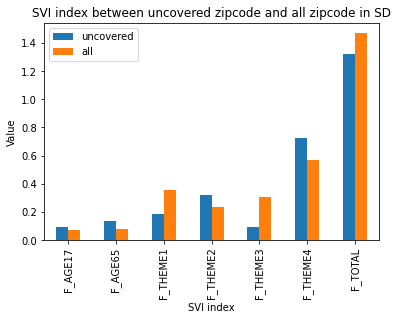

In [71]:
# Plot
import matplotlib.pyplot as plt
mean_info.plot(kind="bar")
plt.title("SVI index between uncovered zipcode and all zipcode in SD")
plt.xlabel("SVI index")
plt.ylabel("Value")

From this plot we can see that for both risky group percentage and 2 of 4 themes, uncovered area is higher than the average of San Diego Area, which means population in uncovered area risk more in these aspects when facing emergent health problems. Then we calculate the weighted score from these flags and the population:  we first normalized the total population, then we use the formula (total population)x0.3 + (percentage of population over 65) x 0.3 + (percentage of population under 19) x 0.3+ (Total flag number)x0.4

In [72]:
population_info = population_cleaned[['zcta','prop_65','prop_19','tot_pop']]
zip_details = zip_tract.merge(SVI_cleaned, left_on='tract', right_on='FIPS').groupby('zip')\
[selected_columns].mean().reset_index()
zip_details = zip_details.merge(population_info, left_on='zip', right_on ='zcta')
zip_details['tot_pop'] = zip_details['tot_pop']/sum(zip_details['tot_pop'])
zip_details['score'] = zip_details['tot_pop']*0.3+zip_details['prop_65']*.3+zip_details['prop_19']*0.3\
+zip_details['F_TOTAL']*0.4
zip_details

,zip,F_AGE17,F_AGE65,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,zcta,prop_65,prop_19,tot_pop,score
0,91901,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,91901,0.132793,0.269494,0.005560,0.322354
1,91902,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.142857,91902,0.170736,0.238883,0.005640,0.181720
2,91905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,91905,0.165294,0.214706,0.000543,0.114163
3,91906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,91906,0.115522,0.309071,0.001159,0.127726
4,91910,0.000000,0.045455,0.454545,0.181818,0.363636,0.954545,1.954545,91910,0.123717,0.281127,0.024216,0.910536
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,92154,0.117647,0.000000,1.117647,0.235294,1.411765,1.117647,3.882353,92154,0.098585,0.297298,0.025464,1.679345
105,92155,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,3.000000,92155,0.000000,0.123636,0.000176,1.237144
106,92173,0.142857,0.000000,2.428571,0.428571,2.000000,1.000000,5.857143,92173,0.091338,0.357844,0.009402,2.480432
107,92536,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,3.000000,92536,0.209449,0.219160,0.001217,1.328948


### Step 3 
In this step, we choose the center of each zipcode as a demand point since the center of a polygon should make the distribution evenly. 

In [73]:
# find the demand point in the tract

In [74]:
geo = population_cleaned_df[population_cleaned_df['zcta'].isin(zipcode_target)][['zcta','geometry']]
sdf_final= sdf_need.merge(geo)
centroid = gpd.GeoDataFrame(sdf_final).centroid
centroid_final=[Geometry.from_shapely(shapely_geometry=i,spatial_reference={'wkid': 3857}) for i in centroid]
centroid_final

[{'x': -13001059.26781612,
  'y': 3856718.356358238,
  'spatialReference': {'wkid': 3857}},
 {'x': -12963525.512818512,
  'y': 3878013.5396533636,
  'spatialReference': {'wkid': 3857}},
 {'x': -12932256.96002362,
  'y': 3850068.073102504,
  'spatialReference': {'wkid': 3857}},
 {'x': -13072115.863379318,
  'y': 3931167.100008026,
  'spatialReference': {'wkid': 3857}},
 {'x': -13007525.958612155,
  'y': 3940627.385528629,
  'spatialReference': {'wkid': 3857}},
 {'x': -13073897.062418215,
  'y': 3946890.1632178496,
  'spatialReference': {'wkid': 3857}},
 {'x': -12975145.192385046,
  'y': 3874930.9641549857,
  'spatialReference': {'wkid': 3857}},
 {'x': -12965852.739679055,
  'y': 3865826.8131929184,
  'spatialReference': {'wkid': 3857}},
 {'x': -12980969.001637228,
  'y': 3845797.9138866984,
  'spatialReference': {'wkid': 3857}},
 {'x': -12981986.963894406,
  'y': 3840859.1318360055,
  'spatialReference': {'wkid': 3857}},
 {'x': -12924616.543324877,
  'y': 3913878.248037177,
  'spatialRe

In [75]:
# add to demand point layer
sdf_demand =sdf_final.copy()
sdf_demand= sdf_demand[['zcta','SHAPE','tot_pop']].merge(zip_details[['zip','score']],left_on='zcta', right_on = 'zip')
sdf_demand['SHAPE']=centroid_final
gdf_demand  = gpd.GeoDataFrame(sdf_demand[['zcta','SHAPE','score']])
#gis.content.get('8ee8d85f3a10444d833226c34e34fcd4').delete()
demand_layer= gdf_demand.spatial.to_featurelayer(title='San Diego demand 170',gis=gis, tags='sample')
demand_layer.id 

'5b2482b4e05a4cf3934076feae817ca0'

### Step 4
From all possible locations in the vacant area, we have to first filter out location that is too far from the highway; then for each demand point, we find the closest polygon by calculating geometric distances. After pairing points and polygon, we find the closet point in the chosen polygon to demand point as the candidate location of possible new health center

In [76]:
# get highway layer
highway_layer= highway.spatial.to_featurelayer(title='San Diego Highway 170',gis=gis, tags='sample')
highway_layer.id  

'b7127c6c322049f6aa7a4fa7b9e40e2c'

In [77]:
# create a buffer around each highway
high_way_buffer =  use_proximity.create_buffers(highway_layer, 
                                                    distances=[10], 
                                                    units = 'Miles', 
                                                    dissolve_type = 'Dissolve')

In [78]:
# get the correspoding sdef
highway_buffer_sdf=high_way_buffer.query().sdf

In [79]:
# join with vacant land to filter out place that is hard to reach
vacant_qualified = Vacant.spatial.join(highway_buffer_sdf)
vacant_qualified  = gpd.GeoDataFrame(vacant_qualified,geometry = 'SHAPE').set_crs('EPSG:3857')
vacant_qualified

,FID_left,lu,Landuse,Shape_STAr,Shape_STLe,Shape__Area,Shape__Length,SHAPE,index_right,FID_right,BUFF_DIST,AnalysisArea
0,1,9101,Vacant and Undeveloped Land,1.142769e+06,11143.329666,152090.503906,4065.280505,"MULTIPOLYGON (((-13064574.328 3923676.656, -13...",0,1,10,5759.878179
1,2,9101,Vacant and Undeveloped Land,3.269556e+05,2348.918595,43516.984375,857.144965,"MULTIPOLYGON (((-13056768.393 3923846.363, -13...",0,1,10,5759.878179
2,3,9101,Vacant and Undeveloped Land,1.020255e+05,1443.912229,13579.503906,526.725265,"MULTIPOLYGON (((-13058363.703 3923808.676, -13...",0,1,10,5759.878179
3,4,9101,Vacant and Undeveloped Land,3.377528e+05,2440.056679,44954.886719,889.842584,"MULTIPOLYGON (((-13056340.361 3923921.092, -13...",0,1,10,5759.878179
4,5,9101,Vacant and Undeveloped Land,1.216871e+06,4748.739143,161966.578125,1731.222414,"MULTIPOLYGON (((-13057497.313 3923716.463, -13...",0,1,10,5759.878179
...,...,...,...,...,...,...,...,...,...,...,...,...
11220,11385,9101,Vacant and Undeveloped Land,1.819598e+05,2975.767349,24229.554688,1085.342467,"MULTIPOLYGON (((-13049748.277 3926461.457, -13...",0,1,10,5759.878179
11221,11386,9101,Vacant and Undeveloped Land,2.226476e+04,702.816768,2964.843750,256.780966,"MULTIPOLYGON (((-13049276.213 3926540.831, -13...",0,1,10,5759.878179
11222,11387,9101,Vacant and Undeveloped Land,4.559012e+04,975.595150,6070.949219,355.879231,"MULTIPOLYGON (((-13049007.122 3926659.757, -13...",0,1,10,5759.878179
11223,11388,9101,Vacant and Undeveloped Land,2.869262e+05,2409.328469,38207.714844,878.696899,"MULTIPOLYGON (((-13052326.818 3926513.896, -13...",0,1,10,5759.878179


In [80]:
# find the closest polygon for each centroid
def take_second(elem):
    return elem[1]
distance = []
for i in centroid:
    distance.append(sorted(list(zip(vacant_qualified['FID_left'],vacant_qualified.distance(i))),key=take_second)[0])
distance

[(3302, 0.0),
 (4582, 1873.7485158709414),
 (2630, 678.917191867149),
 (8241, 1840.546977675547),
 (8359, 1168.991274417303),
 (9045, 11855.951103079307),
 (4399, 240.8224670969591),
 (3638, 2064.1635155831805),
 (3284, 80.56960088284389),
 (2353, 119.1466164958175),
 (6557, 59.756714262360234),
 (8958, 8813.148838558327),
 (5141, 2407.2161419985523),
 (6618, 1473.0699977240838),
 (4668, 1014.6749767839855),
 (2422, 211.62156401765716),
 (2898, 0.0),
 (8206, 1553.4374952163132),
 (9032, 2635.374292419015),
 (7215, 0.0)]

In [81]:
# find the nearest point in the chosen vacant place
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points

location = []
for i in range(len(centroid)):
    vacant_candidate = vacant_qualified[vacant_qualified['FID_left']==distance[i][0]]['SHAPE'].values[0]
    location.append(nearest_points(vacant_candidate, centroid[i])[0])
location_final=[Geometry.from_shapely(shapely_geometry=i,spatial_reference={'wkid': 3857}) for i in location]
location_final

[{'x': -13001059.26781612,
  'y': 3856718.356358238,
  'spatialReference': {'wkid': 3857}},
 {'x': -12965310.1712971,
  'y': 3877442.63894787,
  'spatialReference': {'wkid': 3857}},
 {'x': -12932931.1736092,
  'y': 3849988.29469421,
  'spatialReference': {'wkid': 3857}},
 {'x': -13071624.1560656,
  'y': 3929393.44922654,
  'spatialReference': {'wkid': 3857}},
 {'x': -13008269.6964394,
  'y': 3939725.5015871,
  'spatialReference': {'wkid': 3857}},
 {'x': -13064855.9907262,
  'y': 3954559.7524649,
  'spatialReference': {'wkid': 3857}},
 {'x': -12975311.4250248,
  'y': 3875105.21159439,
  'spatialReference': {'wkid': 3857}},
 {'x': -12967615.5957996,
  'y': 3864752.98391537,
  'spatialReference': {'wkid': 3857}},
 {'x': -12980911.281936,
  'y': 3845854.12684496,
  'spatialReference': {'wkid': 3857}},
 {'x': -12981986.829221176,
  'y': 3840978.2783763898,
  'spatialReference': {'wkid': 3857}},
 {'x': -12924638.26917932,
  'y': 3913822.580702517,
  'spatialReference': {'wkid': 3857}},
 {'x'

In [82]:
# add to candidate point layer
sdf_candidate=sdf_final.copy()
sdf_candidate['SHAPE']=location_final
sdf_candidate=gpd.GeoDataFrame(sdf_candidate[['zcta','SHAPE']])
#gis.content.get('88f23dc0daa845f883e6d427358efa6b').delete()
candidate_layer= sdf_candidate.spatial.to_featurelayer(title='San Diego candidate 170',gis=gis, tags='sample')
candidate_layer.id 

'11bdef8fd58e42549690a90349439f9a'

In [83]:
# add demand point and possible location 
candidate_facilities = candidate_layer.layers[0].query()
candidate_facilities

<FeatureSet> 20 features

### Step 5
For each demand point, we assign the candidate, required, and competitor facilities a new field called FacilityType, and update the weight for each demand point according to the calculated score. 

In [84]:
# update facility type
object_id = 0

for f in candidate_facilities:
    object_id+=1
    f.attributes.update({"FacilityType":0})

In [85]:
# extract demand point value
demand_points = demand_layer.layers[0].query()
demand_points

<FeatureSet> 20 features

In [86]:
# plot the demand point and possible point
demand_map = gis.map('San Diego')
demand_map.add_layer(candidate_layer.layers[0])
demand_map.add_layer(demand_layer.layers[0])
demand_map.add_layer(Vacantitem.layers[0])
demand_map 

MapView(layout=Layout(height='400px', width='100%'))

In [87]:
# update the demand point
for f in demand_points:
    tmp = f.get_value("score")
    f.attributes.update({"Weight":tmp})

In [88]:
for f in candidate_facilities:  
    f.attributes['NAME'] = f.attributes.pop('zcta')

In [89]:
candidate_facilities.sdf

,FID,FacilityType,NAME,SHAPE
0,1,0,91935,"{""x"": -13001059.26781612, ""y"": 3856718.3563582..."
1,2,0,91948,"{""x"": -12965310.1712971, ""y"": 3877442.63894787..."
2,3,0,91934,"{""x"": -12932931.1736092, ""y"": 3849988.29469421..."
3,4,0,92054,"{""x"": -13071624.1560656, ""y"": 3929393.44922654..."
4,5,0,92060,"{""x"": -13008269.6964394, ""y"": 3939725.5015871,..."
5,6,0,92055,"{""x"": -13064855.9907262, ""y"": 3954559.7524649,..."
6,7,0,91931,"{""x"": -12975311.4250248, ""y"": 3875105.21159439..."
7,8,0,91962,"{""x"": -12967615.5957996, ""y"": 3864752.98391537..."
8,9,0,91963,"{""x"": -12980911.281936, ""y"": 3845854.12684496,..."
9,10,0,91980,"{""x"": -12981986.829221176, ""y"": 3840978.278376..."


### Step 6
Finally, we adopted solve_location_allocation to see if our planning is reasonable or not. We used the Maximize Attendance and we try to find 3 facilities for each demand points within 10 minutes drive. 

In [90]:
allocation_work = network.analysis.solve_location_allocation(   problem_type='Maximize Attendance',
                                                        travel_direction='Demand to Facility',
                                                        number_of_facilities_to_find='3',
                                                        measurement_transformation_model="Linear",
                                                        measurement_transformation_factor=2,
                                                        demand_points=demand_points,
                                                        facilities=candidate_facilities,
                                                        measurement_units='Minutes',
                                                        default_measurement_cutoff=10
                                                    )
print('Analysis succeeded? {}'.format(allocation_work.solve_succeeded))

Analysis succeeded? True


In [91]:
demand = allocation_work.output_demand_points.sdf
lines = allocation_work.output_allocation_lines.sdf
facilities = allocation_work.output_facilities.sdf

In [92]:
# plot the allocation line
allocation_map = gis.map('San Diego')
allocation_map.add_layer(demand_layer.layers[0])
lines.spatial.plot(map_widget = allocation_map)

True

In [96]:
allocation_map

MapView(jupyter_target='notebook', layout=Layout(height='400px', width='100%'), ready=True)

In this analysis part, we have sticked to our original proposals, while we add some details when deciding the possible location and weight calculation. 

## Summary of products and results 

In [93]:
demand_map 

MapView(layout=Layout(height='400px', width='100%'))

In this project, we have found 20 zipcodes that cannot found a CDPH Licensed Health Center within 10 miles. From the above map we can see that most of these zipcodes lying on the boundary of the San Diego County. These zipcodes do contain some of populations, so they cannot be ignored. Also, according to the statistics analysis, we see the population number and  percentage in these areas tend to be higher than most in San Diego County, while some of these zipcodes even reaches 90% percentage of risky popuaccording to the . The SVI index in these areas, especially for the age index, household and transportation index, also indicate that these 20 zipcodes are more sensitive to major health problems than other areas. Thus, it means we have to make sure these zipcodes have a corresponding health center so that resources can be allocated efficiently for people who are more likely to be affected in pandemic or other health emergency. By adding possible location to the uncovered zipcode, we try to improve the current system by having more service provider.   After having allocation analysis, we find that by adding a health center  to each demand point can solve the problem of not having enough health centered covered and each zipcode can find 3 facilities to meet their demand. 


## Discussion

- From this project, we have found that though most of the zipcodes in San Diego county can find a CDPH Licensed health center in 10 miles. However, some areas of the 20 zipcodes we extracted cannot find a health center in such distance. Those zipcodes, by our analysis, are vulnerable to public health issues, which should be the main users of health center. Thus, on the level of CDPH Licensed health center, we cannot assured that San Diego county has an efficiency health care system. This result is matched with the previous study, but by adding certain possible location, we managed to improve the result, which is not realized in the previous study. Thus, if CDPH want to make its system efficient, more locations should be considered. 
- During the whole process, we make some tradeoffs: in order to have complete records of zipcode, we replace 0 with the null value(-999) in SVI index. Thus, the value of the mean for county area will be higher, but it will not hurt our conclusion that uncovered area is more sensitive since many of its records are already lower than that of the whole county.  While making joining, we choose arcgis join which would only count “within”. Also, we use a geometric way to calculate the closest polygon and the closest point to the demand point, which may lead some inaccurate results. 


## Conclusions and future work

From this project, we have met our goal to test and improve the health care system based on CDPH License. However, this project has several limitations: 
- The project assumes that all vacant area is suitable to construct new hospital. However, in reality, the location of hospital is limited by several geographical restrictions (low elevation, flat ground, shouldn’t build on lakes and canyons)
- In this project, it doesn’t consider the hospital type in the allocation system. The majority of the hospital type is community clinic, and this model fails to balance the different types of hospital. 
- CDPH only counts part of the hospital. Thus, we still have no idea what is the overall system look like. 
Thus, future students in DSC170 or experts in health system who have access to all health care facilities can build on the basis of this project to get a more complete result. 